Training data shape: (800, 2), (800,)
Test data shape: (200, 2), (200,)

Best Hyperparameters:
{'hidden_size': 8, 'learning_rate': 0.5, 'batch_size': 64, 'n_epochs': 100}
Best Mean CV Accuracy: 0.9888

Training Set Accuracy: 0.9738
Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       387
           1       1.00      0.95      0.97       413

    accuracy                           0.97       800
   macro avg       0.97      0.97      0.97       800
weighted avg       0.98      0.97      0.97       800


Test Set Accuracy: 0.9850
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        97
           1       1.00      0.97      0.99       103

    accuracy                           0.98       200
   macro avg       0.98      0.99      0.98       200
weighted avg       0.99      0.98      0.99       200



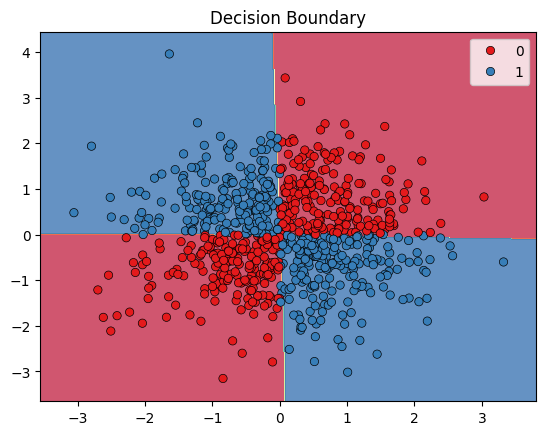

In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import abc
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import KFold

# Load XOR dataset
with open('xordata.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train']  # 800 training data points with 2 features
y_train = data['y_train']  # training binary labels {0,1}

X_test = data['X_test']
y_test = data['y_test']

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")

# Ensure labels are in the correct shape
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# One-hot encode the labels (for compatibility if needed)
def one_hot_encode(y, n_classes):
    return np.identity(n_classes)[y.astype(int).flatten()]

# Define the base Module class
class Module(abc.ABC):
    def __init__(self, name):
        '''
        Stores learnable weights in a dictionary self.weights keyed by strings.
        '''
        self.name = name
        self.weights = {}
        self.grad_weights = {}

    @abc.abstractmethod
    def forward(self, input):
        '''
        Computes the output of the module, then stores the output in self.output and returns it.
        '''
        pass

    @abc.abstractmethod
    def backward(self, grad_output):
        '''
        Computes self.grad_weights organized as a dictionary in the same way as self.weights and returns grad_input.
        '''
        pass

    def __repr__(self):
        return self.name

# Define the Composition class (similar to PyTorch's Sequential)
class Composition(Module):
    def __init__(self, submodules):
        self.submodules = submodules
        # Comma-separated string of submodule names
        self.name = f'Composition({", ".join(submodule.name for submodule in submodules)})'
        self.weights = {
            f'{submodule.name}.{weight_name}': weight
            for submodule in self.submodules
            for weight_name, weight in submodule.weights.items()
        }

    def forward(self, input):
        for submodule in self.submodules:
            input = submodule.forward(input)
        self.output = input
        return input

    def backward(self, grad_output):
        for submodule in reversed(self.submodules):
            # The value of submodule.backward is the grad_output for the next submodule
            grad_output = submodule.backward(grad_output)
        # Collect all the grad_weights together
        self.grad_weights = {
            f'{submodule.name}.{weight_name}': grad_weight
            for submodule in self.submodules
            for weight_name, grad_weight in submodule.grad_weights.items()
        }
        return grad_output

# Define the Linear layer
class Linear(Module):
    def __init__(self, n_in_features, n_out_features):
        super().__init__(f'Linear({n_in_features}, {n_out_features})')
        self.n_in_features = n_in_features
        self.n_out_features = n_out_features

        # Initialize weights uniformly
        stdv = 1.0 / np.sqrt(self.n_in_features)
        self.weights = {
            'W': np.random.uniform(-stdv, stdv, (n_out_features, n_in_features)),
            'b': np.random.uniform(-stdv, stdv, (n_out_features,))
        }

    def forward(self, input):
        self.input = input  # Store input for backward pass
        return input @ self.weights['W'].T + self.weights['b']

    def backward(self, grad_output):
        # Compute gradients w.r.t weights and biases
        self.grad_weights = {
            'W': grad_output.T @ self.input,
            'b': grad_output.sum(axis=0)
        }
        # Compute gradient w.r.t input
        grad_input = grad_output @ self.weights['W']
        return grad_input

# Define the ReLU activation function
class ReLU(Module):
    def __init__(self):
        super().__init__('ReLU')

    def forward(self, input):
        self.input = input  # Store input for backward pass
        return np.maximum(0, input)

    def backward(self, grad_output):
        grad_relu = (self.input > 0).astype(float)
        return grad_output * grad_relu

# Define the Sigmoid activation function
class Sigmoid(Module):
    def __init__(self):
        super().__init__('Sigmoid')

    def forward(self, input):
        self.output = 1 / (1 + np.exp(-input))
        return self.output

    def backward(self, grad_output):
        grad_sigmoid = self.output * (1 - self.output)
        return grad_output * grad_sigmoid

# Define the Binary Cross-Entropy loss function
class BinaryCrossEntropy(Module):
    def __init__(self):
        super().__init__('BinaryCrossEntropy')

    def forward(self, input, target):
        self.input = input
        self.target = target
        # For numerical stability
        epsilon = 1e-8
        self.loss = -np.mean(target * np.log(input + epsilon) + (1 - target) * np.log(1 - input + epsilon))
        return self.loss

    def backward(self):
        epsilon = 1e-8
        grad_input = (self.input - self.target) / ((self.input * (1 - self.input)) + epsilon) / len(self.target)
        return grad_input

# Define the SGD optimizer
class SGD:
    def __init__(self, module, lr=1e-3):
        self.module = module
        self.lr = lr

    def step(self):
        for weight_name, weight in self.module.weights.items():
            weight -= self.lr * self.module.grad_weights[weight_name]

# Define the training function with mini-batch SGD
def train(model, loss_fn, optimizer, X_train, y_train, n_epochs=100, batch_size=32):
    losses = []
    for epoch in range(n_epochs):
        # Shuffle the data at the beginning of each epoch
        permutation = np.random.permutation(X_train.shape[0])
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train[permutation]

        # Mini-batch training
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train_shuffled[i:i + batch_size]
            y_batch = y_train_shuffled[i:i + batch_size]

            # Forward pass
            output = model.forward(X_batch)
            # Compute loss
            loss = loss_fn.forward(output, y_batch)
            # Backward pass
            model.backward(loss_fn.backward())
            # Update weights
            optimizer.step()

        # Record loss after each epoch
        output_full = model.forward(X_train)
        loss_full = loss_fn.forward(output_full, y_train)
        losses.append(loss_full)

   

# Function to evaluate the model and print classification report
def evaluate(model, X, y, dataset_name='Dataset'):
    # Forward pass
    output = model.forward(X)
    # Predictions
    y_pred = (output > 0.5).astype(int)
    # Accuracy
    accuracy = accuracy_score(y, y_pred)
    print(f"\n{dataset_name} Accuracy: {accuracy:.4f}")
    # Classification report
    print(f"{dataset_name} Classification Report:")
    print(classification_report(y, y_pred))

# Function to perform cross-validation
def cross_validation(X, y, hidden_size, learning_rate, n_epochs, batch_size, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_scores = []

    for train_index, val_index in kf.split(X):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        # Initialize the model
        model_cv = Composition([
            Linear(2, hidden_size),
            ReLU(),
            Linear(hidden_size, 1),
            Sigmoid()
        ])
        loss_fn = BinaryCrossEntropy()
        optimizer = SGD(model_cv, lr=learning_rate)

        # Train the model
        train(model_cv, loss_fn, optimizer, X_train_fold, y_train_fold, n_epochs, batch_size)

        # Evaluate on validation set
        output = model_cv.forward(X_val_fold)
        y_val_pred = (output > 0.5).astype(int)
        accuracy = accuracy_score(y_val_fold, y_val_pred)
        cv_scores.append(accuracy)

    mean_cv_score = np.mean(cv_scores)
    return mean_cv_score

# Hyperparameter grids
hidden_sizes = [4, 8, 16, 32]
learning_rates = [0.01, 0.1, 0.5]
batch_sizes = [16, 32, 64]
epochs_list = [50, 100]

best_score = 0
best_params = {}

# Grid search with cross-validation
for hidden_size in hidden_sizes:
    for learning_rate in learning_rates:
        for batch_size in batch_sizes:
            for n_epochs in epochs_list:
                mean_cv_score = cross_validation(X_train, y_train, hidden_size, learning_rate, n_epochs, batch_size)

                if mean_cv_score > best_score:
                    best_score = mean_cv_score
                    best_params = {
                        'hidden_size': hidden_size,
                        'learning_rate': learning_rate,
                        'batch_size': batch_size,
                        'n_epochs': n_epochs
                    }

print("\nBest Hyperparameters:")
print(best_params)
print(f"Best Mean CV Accuracy: {best_score:.4f}")

# Train the final model with the best hyperparameters
model = Composition([
    Linear(2, best_params['hidden_size']),
    ReLU(),
    Linear(best_params['hidden_size'], 1),
    Sigmoid()
])
loss_fn = BinaryCrossEntropy()
optimizer = SGD(model, lr=best_params['learning_rate'])

# Train the model on the entire training set
train(model, loss_fn, optimizer, X_train, y_train, best_params['n_epochs'], best_params['batch_size'])

# Evaluate on training data
evaluate(model, X_train, y_train, dataset_name='Training Set')

# Evaluate on test data
evaluate(model, X_test, y_test, dataset_name='Test Set')

# Optional: Visualize the decision boundary
def plot_decision_boundary(model, X, y):
    # Create a mesh grid
    h = 0.02
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict over the grid
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.forward(grid)
    Z = (Z > 0.5).astype(int)
    Z = Z.reshape(xx.shape)

    # Plot contour
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    # Plot data points
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y.flatten(), palette="Set1", edgecolor="k")
    plt.title('Decision Boundary')
    plt.show()

# Plot the decision boundary
plot_decision_boundary(model, X_train, y_train)
